# CUWA code

CUWA is 3D/2D full-wave code, developed to investigate the physics of RF wave propagation in the electron cyclotron frequency range in magnetised plasmas. The code utilises the Finite Difference Time Domain (FDTD) technique and takes advantage of massive parallel computations with Graphics Processing Units (GPU).

The system of equations being solved by the code is Maxwell's equations with the addition of a "cold plasma" response current ${\bf J}$ equation given by the electron law of motion:
	$$\dfrac{\partial}{\partial t}{\bf{B}} = - \nabla \times {\bf{E}},$$
	$$\dfrac{\partial}{\partial t}{\bf{E}} = c^2 \nabla \times {\bf{B}}  - {\bf{J}}/\varepsilon_0,$$
	$$\dfrac{d }{dt}{\bf{J}} + \nu {\bf{J}} = \varepsilon_0 \omega_p^2 {\bf{E}} - {\bf{J}} \times \boldsymbol{\omega}_c$$
where $\omega_p^2=n_e e^2/\varepsilon_0 m_e$ is the electron plasma frequency, $\nu$ is the electron collision frequency, $\boldsymbol{\omega}_c = |e|{\bf B}_0/m_e$ is the electron cyclotron frequency (vector) corresponding to the background magnetic field ${\bf B}_0$. 


## Installation
CUWA is written using CUDA framework plus `python` and, therefore, does not require compilation or installation procedures. All you have to do is to copy the lib_CUWA library to any folder and import the library from you own python script. The minimal example is given below. 

## Minimal example

In [1]:
module('load','cuda/11.4')

In [2]:
import numpy as np
import scipy.constants as sc 
import matplotlib.pyplot as plt

In order to use CUWA the core CUWA library `lib_CUWA_core` needs to be imported. In this case it is located in the folder `./lib_CUWA/`, so we add this folder to the `sys.path`. 

In [3]:
import sys,os; sys.path.insert(0, os.path.expanduser('./lib_CUWA/')) #Path to the CUWA libraries folder
import lib_CUWA_core as lib_CUWA #This library contains minimal code needed to run CUWA

In general, CUWA setup consists of three main stages: 
1. **Antennas setup**. Antennas can be sources or receivers (or both simultaneously) and are usually prescribed as Gaussian beams. 
2. **Computation domain**. There are currently two ways of initialising the computational grid: using existing plasma data arrays or setting up an arbitrary located in laboratory frame grid, which is then used to fill in the plasma data.    
3. **Running FDTD time steps**

All the information necessary for solving the problem is stored in the `lib_CUWA.CUWA()` object. Steps 1 and 2 prefill the object with necessary data.

In [4]:
C1 = lib_CUWA.CUWA() # Initialisation of CUWA. When running on local GPU the GPU context is initialised 

15.6 GB is free of total 15.7 GB


### Antenna setup

The spatial distribution of the launched wave field is usually prescribed to have the form of a Gaussian beam
\begin{equation}
 {\bf E}(\rho,s) \sim \dfrac{w_0}{w(s)}\exp\left(-\dfrac{\rho^2}{w^2(s)} -i\left(ks +\dfrac{k\rho^2}{2R(s)} - \varphi_G(s)\right)\right),
   \label{Gauss} 
\end{equation}
where $\rho$ is the radial distance from the centre axis of the beam, $s$ is the axial distance from the beam's focus (or "waist", which has radius $w_0$), 
$R(s)=s(1+z_R^2/s^2)$ is the curvature of the wavefront, 
$w(s)=w_0\sqrt{1+s^2/z_R^2}$ is the beam radius, 
$z_R=\pi w_0^2/\lambda$ is the Rayleigh length, 
$k=\omega/c$ and 
$\varphi_G(s)=\arctan (s/z_R)$ is the Gouy phase.

In CUWA the `gaussian_beam.GaussianBeam` needs to be initialised, contaning the beam frequency, polarisation mode ('O' or 'X'), location of the origin and the focus, and the waist radius $w_0$.

In [5]:
import gaussian_beam
beam = gaussian_beam.GaussianBeam(frequency_GHz = 90,
                                  mode          = 'X',
                                  origin        = np.array((0.05,0,0)),
                                  gaussian_focus= np.array((0.15,0.25,0)),
                                  waist_radius  = 0.035)

beam2= gaussian_beam.GaussianBeam(frequency_GHz = 110,
                                  mode          = 'X',
                                  origin        = np.array((0.0,0.03,0)),
                                  gaussian_focus= np.array((0.2,0.09,0)),
                                  waist_radius  = 0.015)

### Computation domain

Computation domain is arbitrary located Cartesian "box". It is set by the location of the origin, bases vectors ($\bf e_x$, $\bf e_y$) and X axis range and the span of Y and X axis.  

In [6]:
X,Y,Z = C1.set_comp_grid(omega_ref = beam2.w_0, 
                    vac_resolution = 12,
                            origin = np.array((0,0,0)), 
                               e_x = np.array((1,0,0)), 
                               e_y = np.array((0,1,0)), 
                           x_range = (0.0,0.25), 
                           y_range = (0.0,0.1), 
                          z_thick  =  0.0)

When the computation domain grid is initialised, the arrays X,Y,Z are the lab frame coordinates of the grid. They can be used to read the equilibrium in these locations or set the plasma data as a function of these coordinates.

For example, below we set constant magnetic field and a linearly growing density profile.

In [7]:
w_c = sc.e / sc.m_e * 2.4 + 0. * X
w_p = sc.e * np.sqrt(0.3e20 * np.fmax(Y,0)/np.max(Y) /(sc.m_e * sc.epsilon_0))
b_x = b_y = np.zeros_like(X)
b_z = np.ones_like(X)

This plasma data should now be copied to GPU. Also, having the plasma data antennas can be initialised (their polarisation is calculated).

In [8]:
C1.set_plasma_data(w_p, w_c, b_x, b_y, b_z, rampDown_width=25)
C1.set_antenna(beam,boundary='y_min'); C1.set_antenna(beam2,boundary='x_min')

Lastly, we compile cu source; initialise wave fields on GPU ($E_x$,$E_y$,$E_z$,$B_x$,$B_y$,$B_z$,$J_x$,$J_y$,$J_z$,$J_x^{n-1}$,$J_y^{n-1}$,$J_z^{n-1}$) with zeros; and initialise auxiliary fields (such as Poyning vector/antenna storages).

The `import_cu_source` function takes arguments to assign the list of sides which will act as perfect electric conductors (mirrors) as well as the choice of the numerical scheme.  

In [9]:
C1.import_cu_source(PEC = ['xN']) # jit-compilation of cuda source code
C1.init_wave_fields() # this is where E,H,J0,J and PML fields are initialized as zeros on GPU 
C1.init_diag_fields(Poynting=True) # this is where auxlilary fields are initialized 

The following block runs the CUWA for a suggested number of steps.

In [10]:
progress_status = 0; st = 0;
for t in range(C1.suggested_n_steps):
    progress_status, st = lib_CUWA.progress_bar(1.*t/(C1.suggested_n_steps-1),progress_status, st)
    C1.run_source(t,beam); 
    C1.run_source(t,beam2)
    C1.run_step()
    C1.integrate_S(t, C1.suggested_n_steps)

[################################################################################] 100% 
Computation time: 8.9 s


`integrate_S(t, C1.suggested_n_steps)` integrats Poynting vector in time. Its integrals over the surfaces of the computation boundaries, i.e. $P_\mathrm{i}= \frac{1}{\mu_0} \iint (\langle{\bf E}\times{\bf B}\rangle\cdot{\bf n}) \,dS$ are obtained using:

In [11]:
S_L, S_R, S_B, S_T, S_B0  = C1.intensities_from_S()

In [12]:
(S_L+S_R+S_B+S_T)/S_B0

0.012759785

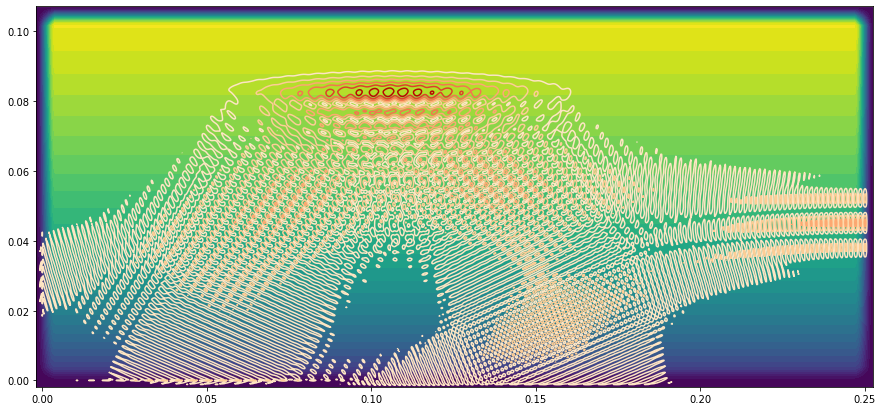

In [13]:
plt.figure(figsize=(15,7))
plt.contourf(X[0],Y[0],C1.w_p[0],30)
plt.contour(X[0],Y[0],C1.get_magE()[0],cmap='OrRd')